# 0.0. Imports

In [1]:
import numpy   as np
import pandas  as pd
import random
import seaborn as sns 
import warnings

from matplotlib import pyplot as plt

from scipy      import stats           as ss
from sklearn    import model_selection as ms
from sklearn    import preprocessing   as pp
from sklearn    import metrics         as m
from scikitplot import metrics         as mt

from sklearn.ensemble      import RandomForestRegressor

from imblearn import under_sampling as us
from imblearn import over_sampling  as osamp
from imblearn import combine        as comb

from category_encoders import TargetEncoder

# from pandas_profiling import ProfileReport

from keras import models as ml
from keras import layers as l

warnings.filterwarnings('ignore')

## 0.1. Auxiliar Functions

In [2]:
def cramer_v(x, y):
    
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    rcorr = r - ((r-1)**2)/(n-1)
    
    kcorr = k - ((k-1)**2)/(n-1)
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    return np.sqrt((chi2corr/n)/(min(kcorr-1, rcorr-1)))

## 0.2. Load Data

In [3]:
# load training set of user
data_users = pd.read_csv('../Datasets/train_users_2.csv', low_memory=False)

# load web sessions log for users
data_sessions = pd.read_csv('../Datasets/sessions.csv', low_memory=False)

# 1.0. Data Description

In [4]:
df01_users = data_users.copy()

df01_sessions = data_sessions.copy()

## 1.1. Data Types

In [5]:
df01_users.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [6]:
df01_sessions.dtypes

user_id           object
action            object
action_type       object
action_detail     object
device_type       object
secs_elapsed     float64
dtype: object

## 1.2. Data Dimensions

### 1.2.1. Data Users Dimensions 

In [7]:
print( f'Number of rows of users dataset: {df01_users.shape[0]}')
print( f'Number of columnss of users dataset: {df01_users.shape[1]}')

Number of rows of users dataset: 213451
Number of columnss of users dataset: 16


### 1.2.2. Data Sessions Dimensions

This dataset will not be used in this first cycle due to the granularity being action and we want to be user_id for now.

In [8]:
print( f'Number of rows of sessions dataset: {df01_sessions.shape[0]}')
print( f'Number of columnss of session dataset: {df01_sessions.shape[1]}')

Number of rows of sessions dataset: 10567737
Number of columnss of session dataset: 6


## 1.3. Check NA

### 1.3.1. Check NA - Data Users

In [9]:
df01_users.isna().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

In [10]:
df01_users.isna().sum()/df01_users.shape[0]

id                         0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.583473
gender                     0.000000
age                        0.412226
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.028414
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
dtype: float64

### 1.3.2. Check NA - Data Sessions

In [11]:
df01_sessions.isna().sum()

user_id            34496
action             79626
action_type      1126204
action_detail    1126204
device_type            0
secs_elapsed      136031
dtype: int64

In [12]:
df01_sessions.isna().sum()/df01_sessions.shape[0]

user_id          0.003264
action           0.007535
action_type      0.106570
action_detail    0.106570
device_type      0.000000
secs_elapsed     0.012872
dtype: float64

## 1.4. Fillout NA

### 1.4.1. Fillout NA - Data Users

- **date_first_booking:** the maximum date of the dataset is chosen due to future features considered the space between dates.

- **age:** variable age has a normal distribution, so replacing it with with a mean value will not bias the dataset.

- **first_affiliate_tracked:** due to the high probability of bias the dataset with categorical data substitution and the low amount of NA datas in this variable, the NA lines will be dropped.

In [13]:
# date_first_booking
max_date_first_booking = pd.to_datetime(df01_users['date_first_booking']).max().strftime('%Y-%m-%d')
df01_users['date_first_booking'] = df01_users['date_first_booking'].fillna(max_date_first_booking)

# age
avg_age = int(df01_users['age'].mean())
df01_users['age'] = df01_users['age'].fillna(avg_age)

# first_affiliate_tracked
df01_users = df01_users[~df01_users['first_affiliate_tracked'].isna()]

In [14]:
df01_users.isna().sum()/df01_users.shape[0]

id                         0.0
date_account_created       0.0
timestamp_first_active     0.0
date_first_booking         0.0
gender                     0.0
age                        0.0
signup_method              0.0
signup_flow                0.0
language                   0.0
affiliate_channel          0.0
affiliate_provider         0.0
first_affiliate_tracked    0.0
signup_app                 0.0
first_device_type          0.0
first_browser              0.0
country_destination        0.0
dtype: float64

### 1.4.2. Fillout NA - Data Sessions

Due to a massise amount of data, all NA lines will be dropped.

In [15]:
# user_id  - 0.003264
df01_sessions = df01_sessions[~df01_sessions['user_id'].isna()]

# action - 0.007535
df01_sessions = df01_sessions[~df01_sessions['action'].isna()]

# action_type - 0.106570
df01_sessions = df01_sessions[~df01_sessions['action_type'].isna()]

# action_detail - 0.106570
df01_sessions = df01_sessions[~df01_sessions['action_detail'].isna()]

# secs_elapsed - 0.012872
df01_sessions = df01_sessions[~df01_sessions['secs_elapsed'].isna()]

In [16]:
df01_sessions.isna().sum()/df01_sessions.shape[0]

user_id          0.0
action           0.0
action_type      0.0
action_detail    0.0
device_type      0.0
secs_elapsed     0.0
dtype: float64

## 1.5. Change Data Type

In [17]:
df01_users.sample(1)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
112453,s5sfn0h3a1,2013-09-29,20130929165140,2013-10-02,-unknown-,49.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari,other


In [18]:
# change date type
df01_users['date_account_created'] = pd.to_datetime(df01_users['date_account_created'])
df01_users['date_first_booking'] = pd.to_datetime(df01_users['date_first_booking'])

# change datetime type
df01_users['timestamp_first_active'] = pd.to_datetime(df01_users['timestamp_first_active'], format='%Y%m%d%H%M%S')

# change age to int
df01_users['age'] = df01_users['age'].astype(np.int64)

In [19]:
df01_users.sample(1)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
44001,jxwyeznnrf,2012-10-08,2012-10-08 15:23:16,2012-10-09,-unknown-,49,basic,0,en,sem-brand,google,untracked,Web,Mac Desktop,Safari,other


In [20]:
df01_users.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int64
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

## 1.6. Check Balanced Data

Data with an unbalance of 57% for the NDF class and 30% for the US class.

In [21]:
df01_users['country_destination'].value_counts(normalize=True)

NDF      0.579673
US       0.294461
other    0.048128
FR       0.023623
IT       0.013458
GB       0.011066
ES       0.010671
CA       0.006707
DE       0.005020
NL       0.003621
AU       0.002541
PT       0.001032
Name: country_destination, dtype: float64

## 1.7. Descriptive Analysis

In [22]:
# split data users in types dataframes
num_attributes_users = df01_users.select_dtypes(include=['int64', 'float64'])
cat_attributes_users = df01_users.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])
time_attributes_users = df01_users.select_dtypes(include=['datetime64[ns]'])

# split data sessions in types dataframes
num_attributes_sessions = df01_sessions.select_dtypes(include=['int64', 'float64'])
cat_attributes_sessions = df01_sessions.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])
time_attributes_sessions = df01_sessions.select_dtypes(include=['datetime64[ns]'])

### 1.7.1. Numerical - Data Users

In [23]:
# tendency central - mean and median
mean_users = pd.DataFrame(num_attributes_users.apply(lambda x: np.mean(x)))
median_users = pd.DataFrame(num_attributes_users.apply(lambda x: np.median(x)))

# dispersions - max, min, range, std, skew and kurtosis
max_users = pd.DataFrame(num_attributes_users.apply(lambda x: x.max()))
min_users = pd.DataFrame(num_attributes_users.apply(lambda x: x.min()))
range_users = pd.DataFrame(num_attributes_users.apply(lambda x: x.max() - x.min()))
std_users = pd.DataFrame(num_attributes_users.apply(lambda x: np.std(x)))
skew_users = pd.DataFrame(num_attributes_users.apply(lambda x: x.skew()))
kurtosis_users = pd.DataFrame(num_attributes_users.apply(lambda x: x.kurtosis()))

# join tendency central and dispersion dataframe
num_stats_users = pd.concat([max_users, min_users, range_users, mean_users, 
                             median_users, std_users, skew_users, kurtosis_users], axis=1).reset_index()
num_stats_users.columns = ['attributes', 'max', 'min', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

num_stats_users

,attributes,max,min,range,mean,median,std,skew,kurtosis
0,age,2014,1,2013,49.183142,49.0,118.421689,16.333820,267.655434
1,signup_flow,25,0,25,3.151490,0.0,7.543915,2.287158,3.567794


### 1.7.2. Numerical - Data Sessions

In [24]:
# tendency central - mean and median
mean_sessions = pd.DataFrame(num_attributes_sessions.apply(lambda x: np.mean(x)))
median_sessions = pd.DataFrame(num_attributes_sessions.apply(lambda x: np.median(x)))

# dispersions - max, min, range, std, skew and kurtosis
max_sessions = pd.DataFrame(num_attributes_sessions.apply(lambda x: x.max()))
min_sessions = pd.DataFrame(num_attributes_sessions.apply(lambda x: x.min()))
range_sessions = pd.DataFrame(num_attributes_sessions.apply(lambda x: x.max() - x.min()))
std_sessions = pd.DataFrame(num_attributes_sessions.apply(lambda x: np.std(x)))
skew_sessions = pd.DataFrame(num_attributes_sessions.apply(lambda x: x.skew()))
kurtosis_sessions = pd.DataFrame(num_attributes_sessions.apply(lambda x: x.kurtosis()))

# join tendency central and dispersion dataframe
num_stats_sessions = pd.concat([max_sessions, min_sessions, range_sessions, mean_sessions, 
                             median_sessions, std_sessions, skew_sessions, kurtosis_sessions], axis=1).reset_index()
num_stats_sessions.columns = ['attributes', 'max', 'min', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

num_stats_sessions

,attributes,max,min,range,mean,median,std,skew,kurtosis
0,secs_elapsed,1799977.0,0.0,1799977.0,19961.8251,1369.0,88849.388449,11.137761,154.84312


### 1.7.3. Categorical - Data Users

In [25]:
cat_attributes_users.drop('id', axis=1).describe()

,gender,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
count,207386,207386,207386,207386,207386,207386,207386,207386,207386,207386
unique,4,3,25,8,18,7,4,9,52,12
top,-unknown-,basic,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
freq,91783,148297,200415,134179,133935,109232,178334,89600,63845,120216


#### 1.7.3.1. Correlation Matrix

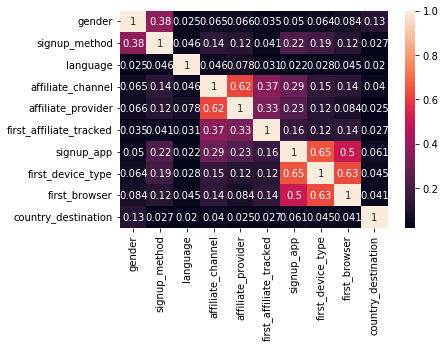

In [26]:
cat_attributes_users_columns = cat_attributes_users.drop('id', axis=1).columns.tolist()

corr_dict = {}

for main_column in cat_attributes_users_columns:
    corr_list = []
    
    for secondary_column in cat_attributes_users_columns:
        # cramer v
        cat_corr = cramer_v( cat_attributes_users[main_column], cat_attributes_users[secondary_column] )
        
        # add to list
        corr_list.append(cat_corr)
    
    # add to dict each attribute correlation 
    corr_dict[main_column] = corr_list

df_corr_users = pd.DataFrame(corr_dict)
df_corr_users = df_corr_users.set_index(df_corr_users.columns)
sns.heatmap(df_corr_users, annot=True);

### 1.7.4. Categorical - Data Sessions

In [27]:
cat_attributes_sessions.drop('user_id', axis=1).describe()

,action,action_type,action_detail,device_type
count,9213930,9213930,9213930,9213930
unique,347,10,155,14
top,show,view,view_search_results,Mac Desktop
freq,2178382,3545621,1770931,3019523


#### 1.7.4.1. Correlation Matrix

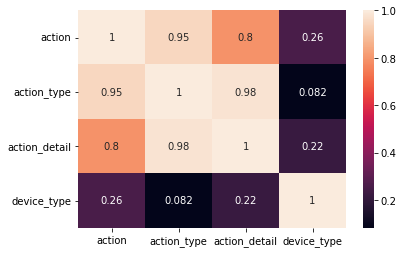

In [28]:
cat_attributes_sessions_columns = cat_attributes_sessions.drop('user_id', axis=1).columns.tolist()

corr_dict = {}

for main_column in cat_attributes_sessions_columns:
    corr_list = []
    
    for secondary_column in cat_attributes_sessions_columns:
        # cramer v
        cat_corr = cramer_v( cat_attributes_sessions[main_column], cat_attributes_sessions[secondary_column] )
        
        # add to list
        corr_list.append(cat_corr)
    
    # add to dict each attribute correlation 
    corr_dict[main_column] = corr_list

df_corr_sessions = pd.DataFrame(corr_dict)
df_corr_sessions = df_corr_sessions.set_index(df_corr_sessions.columns)
sns.heatmap(df_corr_sessions, annot=True);

# 2.0. Feature Engineering

In [29]:
df02_users = df01_users.copy()

In [30]:
df02_users.shape

(207386, 16)

## 2.1. Create Gap Between Dates Features

In [31]:
# date of first active
df02_users['date_first_active'] = pd.to_datetime(df02_users['timestamp_first_active'].dt.strftime("%Y-%m-%d"))

# difference in days between date_account_created and date_first_active
df02_users['diff_account_created_first_active'] = (df02_users['date_account_created'] - df02_users['date_first_active']).apply(lambda x: x.days)

# difference in days between date_account_created and date_first_booking
df02_users['diff_first_booking_account_created'] = (df02_users['date_first_booking'] - df02_users['date_account_created']).apply(lambda x: x.days)

# difference in days between date_first_active and date_first_booking
df02_users['diff_first_active_first_booking'] = (df02_users['date_first_booking'] - df02_users['date_first_active']).apply(lambda x: x.days)

## 2.2. Create Date Features

### 2.2.1. Account Created

In [32]:
# year
df02_users['year_account_created'] = df02_users['date_account_created'].dt.year

# month
df02_users['month_account_created'] = df02_users['date_account_created'].dt.month

# day
df02_users['day_account_created'] = df02_users['date_account_created'].dt.day

# day of week
df02_users['dayofweek_account_created'] = df02_users['date_account_created'].dt.dayofweek

# week of year
df02_users['weekofyear_account_created'] = df02_users['date_account_created'].dt.weekofyear

### 2.2.2. First Active

In [33]:
# year
df02_users['year_first_active'] = df02_users['date_first_active'].dt.year

# month
df02_users['month_first_active'] = df02_users['date_first_active'].dt.month

# day
df02_users['day_first_active'] = df02_users['date_first_active'].dt.day

# day of week
df02_users['dayofweek_first_active'] = df02_users['date_first_active'].dt.dayofweek

# week of year
df02_users['weekofyear_first_active'] = df02_users['date_first_active'].dt.weekofyear

### 2.2.3. First Booking

In [34]:
# year
df02_users['year_first_booking'] = df02_users['date_first_booking'].dt.year

# month
df02_users['month_first_booking'] = df02_users['date_first_booking'].dt.month

# day
df02_users['day_first_booking'] = df02_users['date_first_booking'].dt.day

# day of week
df02_users['dayofweek_first_booking'] = df02_users['date_first_booking'].dt.dayofweek

# week of year
df02_users['weekofyear_first_booking'] = df02_users['date_first_booking'].dt.weekofyear

# 3.0. Data Filtering

In [35]:
df03_users = df02_users.copy()

## 3.1. Filtering Rows

In [36]:
# age - greater than 15 and lower than 120 - There are few people over 120 years old ( Could be error from system or manual imput - Cleaning noise)
df03_users = df03_users[(df03_users['age'] > 15) & (df03_users['age'] < 120)]

# secs_elapsed - there is no possible 0 secs elapesed on website
#df03_sessions = df03_sessions[df03_sessions['secs_elapsed'] > 0]

## 3.2. Columns Selection

In [37]:
# columns used to feature enginnering
cols_date =['timestamp_first_active',
            'date_first_active',
            'date_account_created',
            'date_first_booking']

df03_users = df03_users.drop(columns=cols_date)

# 4.0. Data Exploratory Analysis

In [38]:
df04_users = df03_users.copy()

## 4.1. Univariate Analysis

In [39]:
# profile = ProfileReport(df04_users)

# profile.to_file(output_file='airbnb_booking_statistics.html')

## 4.2. Bivariate Analysis

### H1. Across all destinations, it takes users an average of 15 days to make their first Airbnb booking since their first activation.
**False:** Users take up to 3 days on median to register on the site all destinations.

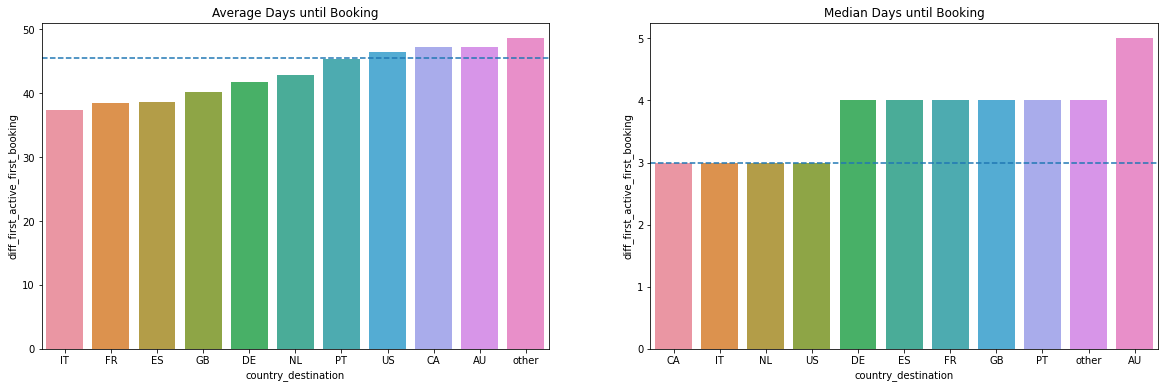

In [40]:
plt.subplots(figsize=(20,6))

# select data with destination
aux = df04_users[df04_users['country_destination'] != 'NDF']

# average number of days from the first active day on website to the first booking for each destination
plt.subplot(1, 2, 1)
aux1 = aux[['diff_first_active_first_booking', 'country_destination']].groupby('country_destination').mean().reset_index()
sns.barplot(x='country_destination', 
            y='diff_first_active_first_booking', 
            data=aux1.sort_values('diff_first_active_first_booking'))
plt.axhline(aux['diff_first_active_first_booking'].mean(), linestyle='--');
plt.title('Average Days until Booking');

# median number of days from the first active day on website to the first booking for each destination
plt.subplot(1, 2, 2)
aux2 = aux[['diff_first_active_first_booking', 'country_destination']].groupby('country_destination').median().reset_index()
sns.barplot(x='country_destination', 
            y='diff_first_active_first_booking',
            data=aux2.sort_values('diff_first_active_first_booking'))
plt.axhline(aux['diff_first_active_first_booking'].median(), linestyle='--');
plt.title('Median Days until Booking');

### H2. In all destinations, it takes users an average of 3 days to register on the site.
**True:** Users register the same day they first visit, on average.

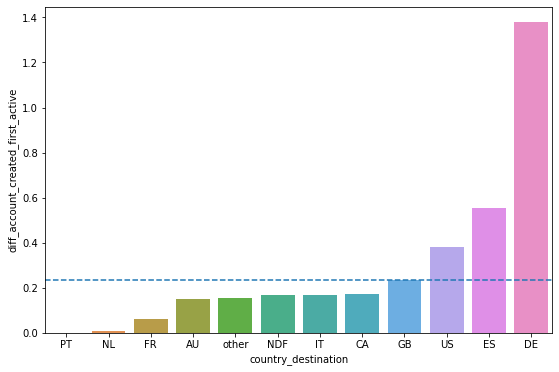

In [41]:
plt.subplots(figsize=(20,6))

# average number of days from the first active day on website to the first booking for each destination
plt.subplot(1, 2, 1)
aux1 = df04_users[['diff_account_created_first_active', 'country_destination']].groupby('country_destination').mean().reset_index()

sns.barplot(x='country_destination', 
            y='diff_account_created_first_active',
            data=aux1.sort_values('diff_account_created_first_active'))
plt.axhline(df04_users['diff_account_created_first_active'].mean(), linestyle='--');

### H3. The annual volume of bookings made during the summer increased by 20% or more for destinations within the USA.
**True:**  Bookings made during the summer for the USA grow by 80% a year on average.

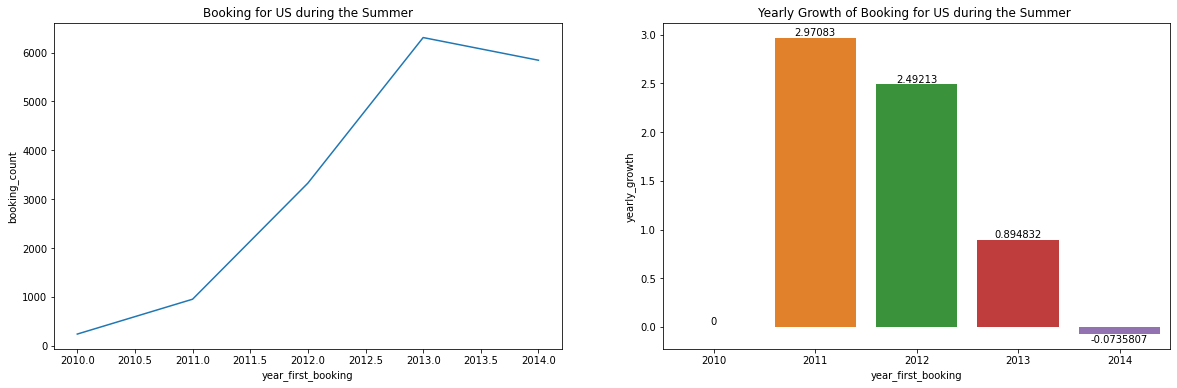

In [42]:
plt.figure(figsize=(20,6))

# number of booking for year, month of firsrt booking and destination by number of rows
aux1 = df04_users[['year_first_booking', 'month_first_booking', 'country_destination']].groupby(
    ['year_first_booking', 'month_first_booking', 'country_destination']
).size().reset_index().rename(columns={0: 'booking_count'})

# seasons for northern hemisphere
season_map = {1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring', 6: 'Summer',
              7: 'Summer', 8: 'Summer', 9: 'Autumn', 10: 'Autumn', 11: 'Autumn', 12: 'Winter'}

# seasons for each month of first booking
aux1['season'] = aux1['month_first_booking'].map(season_map)

# select data targeting the USA and the summer season 
aux2 = aux1[(aux1['country_destination'] == 'US') & (aux1['season'] == 'Summer') & (aux1['year_first_booking'] != 2015)]

# number of bookings for first booking year
aux3 = aux2[['year_first_booking', 'booking_count']].groupby('year_first_booking').sum().reset_index()

plt.subplot(1, 2, 1)
sns.lineplot(x='year_first_booking', y='booking_count', data=aux3)
plt.title('Booking for US during the Summer');

# porcentage of growth to each first booking year
aux3['yearly_growth'] = aux3['booking_count'].pct_change().fillna(0)

# yearly growth of first booking for US during the summer
plt.subplot(1, 2, 2)
ax = sns.barplot(x='year_first_booking', y='yearly_growth', data=aux3);
ax.bar_label(ax.containers[0]);
plt.title('Yearly Growth of Booking for US during the Summer ');



### H4. Female users make 10% more reservations for countries outside the USA.
**False:** Female users make more than 15% more reservations than male users.

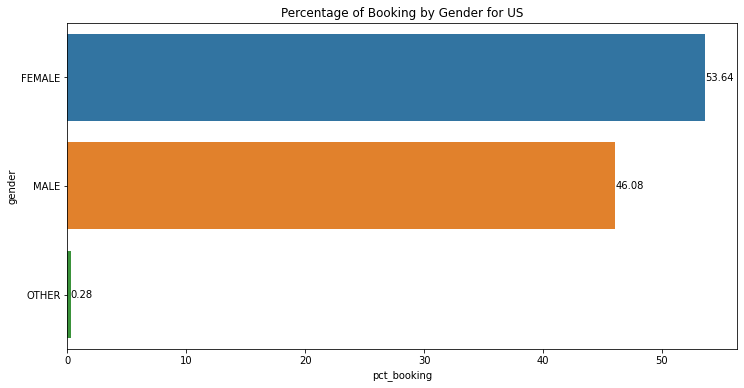

In [43]:
plt.figure(figsize=(12, 6))

# number of booking for gender and destination
aux1 = df04_users[['gender', 'country_destination']].groupby(
    ['gender', 'country_destination']
).size().reset_index().rename(columns={0: 'booking_count'})

# select data for US and droped unknow rows
aux2 = aux1[(aux1['country_destination'] == 'US') & (aux1['gender'] != '-unknown-')]

# percentage of bookings for each gender
aux2['pct_booking'] = round(100*(aux2['booking_count']/aux2['booking_count'].sum()), 2)

# percentage of bookings for each gender for US destination
ax = sns.barplot(x='pct_booking', y='gender', data=aux2);
ax.bar_label(ax.containers[0]);
plt.title('Percentage of Booking by Gender for US');

### H5. The Google Marketing channel accounts for more than 40% of bookings to countries outside the USA.
**True:** Considering only paid channel, Marketing Google represents 76% of bookings.

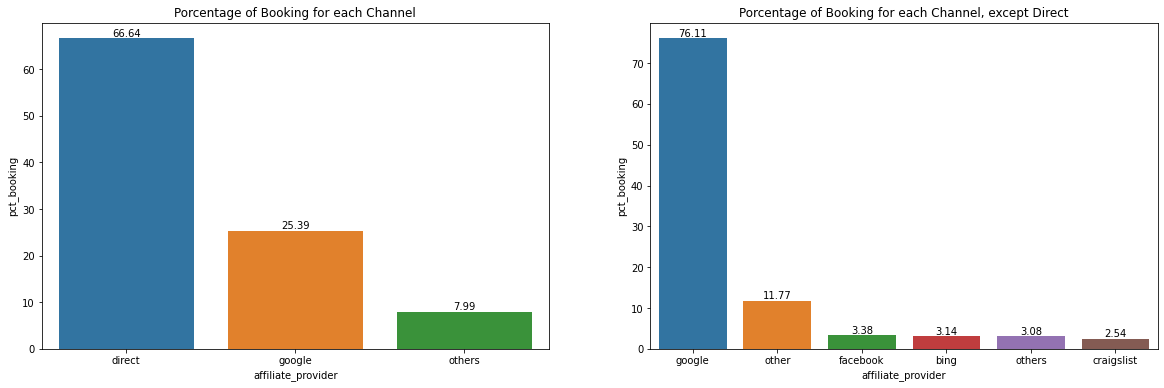

In [44]:
plt.figure(figsize=(20, 6))

# select data with destination and without US
aux = df04_users[(df04_users['country_destination'] != 'US') & (df04_users['country_destination'] != 'NDF')]

# number of booking por each affiliate
aux1 = aux[['affiliate_provider']].groupby('affiliate_provider').size().reset_index().rename(columns={0: 'booking_count'})

# porcentage of booking for each affiliate
aux1['pct_booking'] = round(100*aux1['booking_count']/aux1['booking_count'].sum(), 2)

# group values smaller than 10
aux2 = aux1['pct_booking'].groupby(
    np.where(aux1['pct_booking'] >=10, aux1['affiliate_provider'], 'others')
).sum().reset_index().rename(columns={'index': 'affiliate_provider'})

# percentage of booking for each channel
plt.subplot(1, 2, 1)
ax = sns.barplot(x='affiliate_provider', y='pct_booking', data=aux2)
ax.bar_label(ax.containers[0]);
plt.title('Porcentage of Booking for each Channel');

#not include organic channels
aux3 = aux[aux['affiliate_provider'] != 'direct']

# number of booking por each affiliate
aux4 = aux3[['affiliate_provider']].groupby('affiliate_provider').size().reset_index().rename(columns={0: 'booking_count'})

# porcentage of booking for each affiliate
aux4['pct_booking'] = round(100*aux4['booking_count']/aux4['booking_count'].sum(), 2)

# group values smaller than 10
aux5 = aux4['pct_booking'].groupby(
    np.where(aux4['pct_booking'] > 1, aux4['affiliate_provider'], 'others')
).sum().reset_index().rename(columns={'index': 'affiliate_provider'}).sort_values('pct_booking', ascending=False)

# percentage of booking for each channel
plt.subplot(1, 2, 2)
ax = sns.barplot(x='affiliate_provider', y='pct_booking', data=aux5)
ax.bar_label(ax.containers[0]);
plt.title('Porcentage of Booking for each Channel, except Direct');

### H6. The USA destination represents more than 20% in all channels.
**True:** USA represents 69% of bookings on average in all channels.

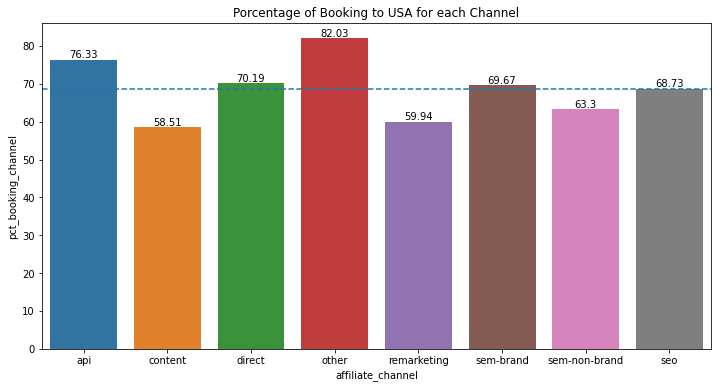

In [45]:
plt.figure(figsize=(12, 6))

# select data with distination
aux = df04_users[df04_users['country_destination'] != 'NDF']

# number of booking for each destination and affiliate channel
aux1 = aux[['country_destination', 'affiliate_channel']].groupby(
    ['country_destination', 'affiliate_channel']
).size().reset_index().rename(columns={0: 'booking_count'})

# create column for porcentage of booking for each channel
aux1['pct_booking_channel'] = np.nan

# porcentage individual for each affiliate channel
for channel in aux1['affiliate_channel'].unique().tolist():
    ref_channel = aux1['affiliate_channel'] == channel
    aux1.loc[ref_channel, 'pct_booking_channel'] = np.round(
        100 * aux1.loc[ref_channel, 'booking_count'] / aux1.loc[ref_channel, 'booking_count'].sum(), 2
)

# select destination for US
aux2 = aux1[aux1['country_destination'] == 'US']

# percentage of bookings for channels for US destination 
ax = sns.barplot(x='affiliate_channel', y='pct_booking_channel', data=aux2)
ax.bar_label(ax.containers[0]);
plt.axhline(aux2['pct_booking_channel'].mean(), linestyle='--')
plt.title('Porcentage of Booking to USA for each Channel');

### H7. The average age of people is 35 in all destinations.
**False:** Average age for all destinations is 40 years old.

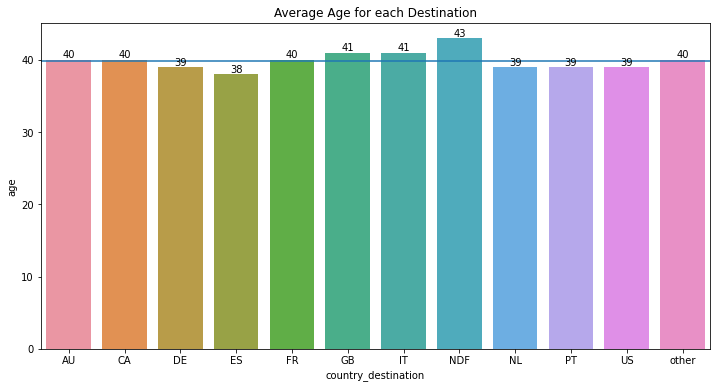

In [46]:
plt.figure(figsize=(12, 6))

# grouped country destination
aux1 = df04_users[['age', 'country_destination']].groupby('country_destination').mean().astype(int).reset_index()

# average age for each destination
ax = sns.barplot(x='country_destination', y='age', data=aux1);
ax.bar_label(ax.containers[0]);
plt.axhline(aux1['age'].mean());
plt.title('Average Age for each Destination');

### H8. The percentage of users who use the English language site to book accommodations at any destination is over 90%.
**True:** English is dominant among users, accounting for 97%.  

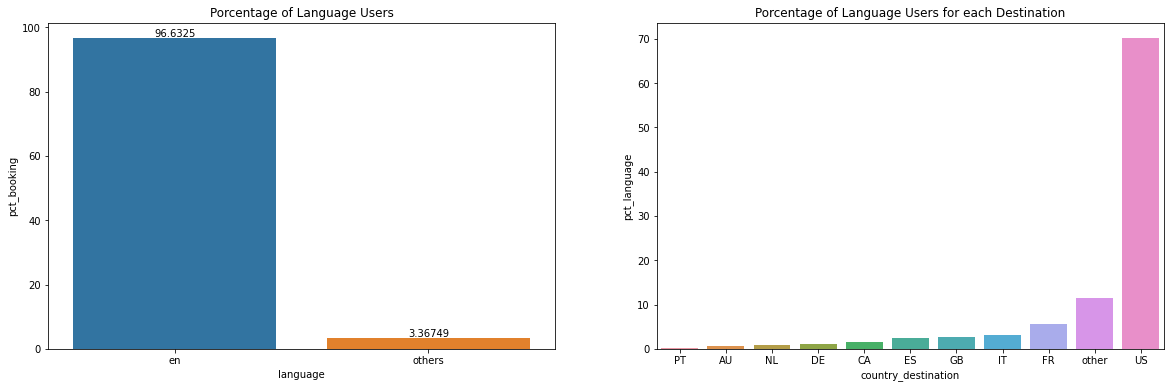

In [47]:
plt.figure(figsize=(20,6))

# number of booking for each language
aux1 = df04_users[['language']].groupby('language').size().reset_index().rename(columns={0: 'booking_count'})

# porcentage of bookings for each language
aux1['pct_booking'] = 100*aux1['booking_count']/aux1['booking_count'].sum()

# grouped values smaller than 1%
aux2 =aux1[['pct_booking']].groupby(
    np.where(aux1['pct_booking'] >= 1, aux1['language'], 'others')
).sum().reset_index().rename(columns={'index': 'language'}).sort_values('pct_booking', ascending=False)

# porcentage of booking for language
plt.subplot(1, 2, 1)
ax = sns.barplot(x='language', y='pct_booking', data=aux2)
ax.bar_label(ax.containers[0]);
plt.title('Porcentage of Language Users');

# select data with destination and without english language
aux = df04_users[(df04_users['language'] == 'en') & (df04_users['country_destination'] != 'NDF')]

# number of language users for each destination
aux3 = aux[['country_destination', 'language']].groupby('country_destination').count().reset_index().sort_values('language')

# porcentage of language users for destination
aux3['pct_language'] = 100 * aux3['language'] / aux3['language'].sum()

# porcentage of language users without english for each destination
plt.subplot(1, 2, 2)
sns.barplot(x='country_destination', y='pct_language', data=aux3);
plt.title('Porcentage of Language Users for each Destination');

### H9. Is the number of Airbnb bookings decreasing over the years.
**False:** The number of Airbnb bookings is growing, but the growth rate has been slowing down over the years.

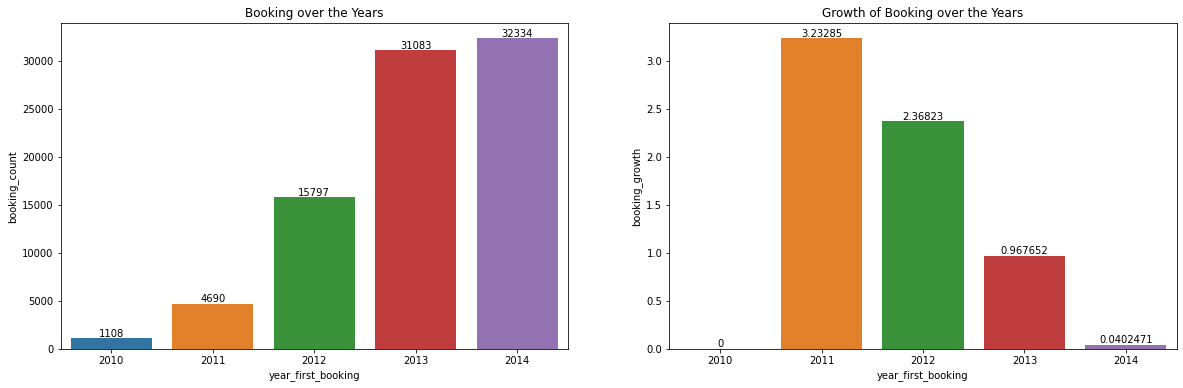

In [48]:
plt.figure(figsize=(20,6))

# select data with complete years and with booking
aux = df04_users[(df04_users['country_destination'] != 'NDF') & 
                  (df04_users['year_first_booking'] < df04_users['year_first_booking'].max())]

# number of booking for each year
aux1 = aux[['year_first_booking']].groupby('year_first_booking').size().reset_index().rename(columns={0: 'booking_count'})

# growth of booking over the years
aux1[['booking_growth']] = aux1[['booking_count']].pct_change().fillna(0)

# number of booking over years
plt.subplot(1, 2, 1)
ax = sns.barplot(x='year_first_booking', y='booking_count', data=aux1 );
ax.bar_label(ax.containers[0]);
plt.title('Booking over the Years');

# growth of booking over the year
plt.subplot(1, 2, 2)
ax = sns.barplot(x='year_first_booking', y='booking_growth', data=aux1);
ax.bar_label(ax.containers[0]);
plt.title('Growth of Booking over the Years');

### H10. Airbnb's booking growth for USA is higher than for other destinations over the years.
**True:** The number of bookings for USA is the highest among all destinations over the years.

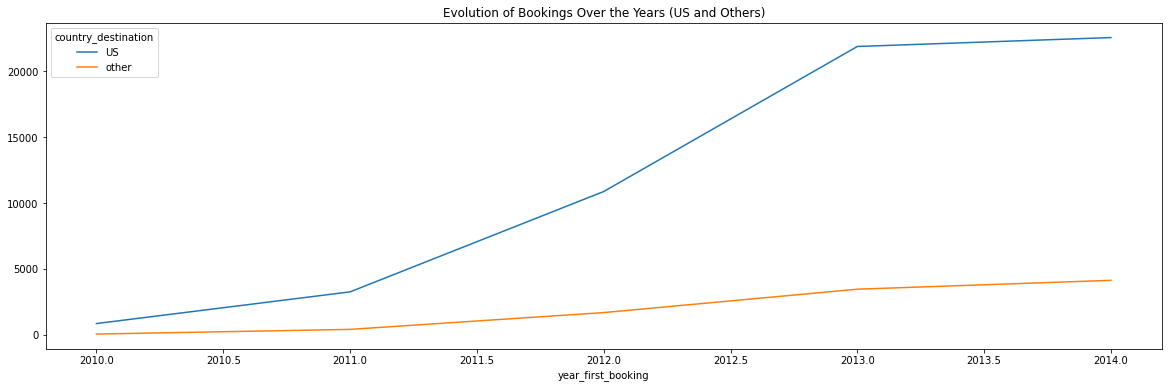

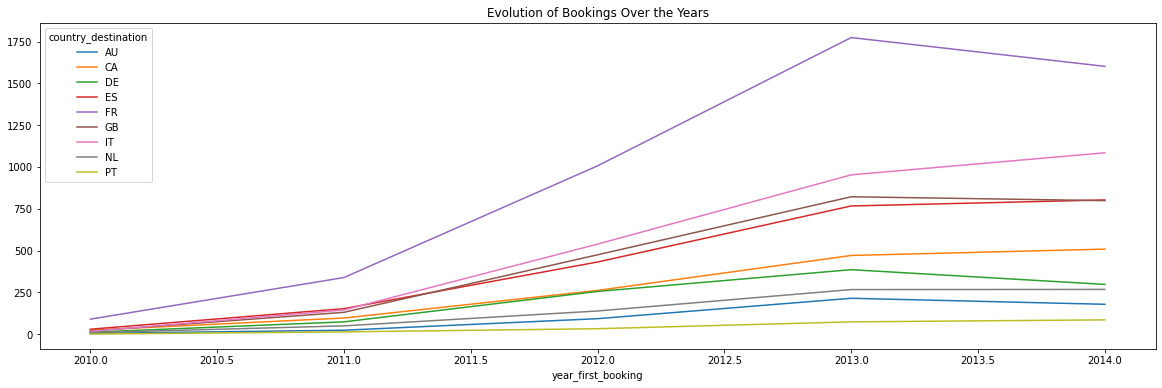

In [49]:
# complete years and with booking
aux = df04_users[(df04_users['country_destination'] != 'NDF') & 
                  (df04_users['year_first_booking'] < df04_users['year_first_booking'].max())]

# number of booking through the year and for each destination
aux1 = aux[['year_first_booking', 'country_destination']].groupby(
    ['year_first_booking', 'country_destination']
).size().reset_index().rename(columns={0: 'booking_count'})

# select data for marjority destinations
aux2 = aux1[(aux1['country_destination'] == 'US') | (aux1['country_destination'] == 'other') ]

aux2.pivot_table(values='booking_count', 
                 index='year_first_booking', 
                 columns='country_destination',
                 aggfunc='sum', 
                 fill_value=0).plot(figsize=(20,6), title='Evolution of Bookings Over the Years (US and Others)');

aux3 = aux1[(aux1['country_destination'] != 'US') & (aux1['country_destination'] != 'other') ]

aux3.pivot_table(values='booking_count', 
                 index='year_first_booking', 
                 columns='country_destination',
                 aggfunc='sum', 
                 fill_value=0).plot(figsize=(20,6), title='Evolution of Bookings Over the Years');

## 4.3. Multivariate Analysis

### 4.3.1. High Correlation Attributes

**Numerical Variables**

diff_first_booking_account_created x diff_first_active_first_booking
    
    remove: diff_first_active_first_booking
    
year_account_created x year_first_active

    remove: year_first_active
        
month_account_created x weekofyear_account_created

    remove: weekofyear_account_created
    
month_account_created x month_first_active

    remove: month_first_active

month_account_created x weekofyear_first_active

    remove: weekofyear_first_active
    
day_account_created x day_first_active

    remove: day_first_active
    
dayofweek_account_created x dayofweek_first_active

    remove: dayofweek_first_active
    
weekofyear_account_created x month_first_active
    
    remove: month_first_active

weekofyear_account_created x weekofyear_first_active

    remove: weekofyear_first_active
    
month_first_active x weekofyear_first_active

    remove: weekofyear_first_active
    
month_first_booking x weekofyear_first_booking

    remove: weekofyear_first_booking

**Categorical Variables**

affiliate_channel x affiliate_provider

    remove: affiliate_provider

signup_app x first_device_type

    remove: first_device_type

first_device_type x first_browser

    remove: first_browser

### 4.3.2. Manual Attributes Selection

In [39]:
# high correlation columns
cols_correlation = ['diff_first_active_first_booking',
                    'year_first_active',
                    'weekofyear_account_created',
                    'month_first_active',
                    'weekofyear_first_active',
                    'day_first_active',
                    'dayofweek_first_active',
                    'weekofyear_first_active',
                    'weekofyear_first_booking',
                    'affiliate_provider',
                    'first_device_type',
                    'first_browser']

# columns with a unique value (>95%)
cols_unique_values = ['language']

# columns to be manual droped
cols_manual_select = cols_correlation + cols_unique_values

# manual select dataset
df04_users = df04_users.drop(columns=cols_manual_select)

# 5.0. Data Preparation

In [40]:
df05_users = df04_users.copy()

## 5.1. Balanced Dataset

### 5.1.1. Encode Categorical Features 

In [41]:
# Enconder Categorical Variables
ohe = pp.OneHotEncoder()

# Numerical
cols_num = df05_users.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Categorical
cols_cat = df05_users.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]']).drop(['id', 'country_destination'], axis=1).columns.tolist()

# Datetime - not used
cols_date = df05_users.select_dtypes(include=['datetime64[ns]']).columns.tolist()

# Encoding
df05_users_dummy =  pd.DataFrame(ohe.fit_transform(df05_users[cols_cat]).toarray(), index=df05_users.index)

# Join numerical and categorical
df05_users_encoder = pd.concat([df05_users[cols_num], df05_users_dummy], axis=1)

### 5.1.2. Random Undersampling

In [42]:
# define sampler - random under-sampling
undersampling = us.RandomUnderSampler(sampling_strategy='not minority', random_state=32)

# resample the dataset
X_under, y_under = undersampling.fit_resample(df05_users_encoder, df05_users['country_destination'])

In [43]:
df05_users['country_destination'].value_counts()

NDF      119810
US        60800
other      9935
FR         4881
IT         2776
GB         2285
ES         2203
CA         1385
DE         1033
NL          746
AU          526
PT          213
Name: country_destination, dtype: int64

In [44]:
y_under.value_counts()

NDF      213
FR       213
CA       213
ES       213
NL       213
GB       213
AU       213
US       213
other    213
PT       213
DE       213
IT       213
Name: country_destination, dtype: int64

In [45]:
# Convert Back to Original Representation
# Numerical
X_under_num = X_under[cols_num]

# inverse transform categorical dataset 
X_under_cat = pd.DataFrame(
    ohe.inverse_transform(X_under.drop(columns=cols_num)), columns=cols_cat, index=X_under.index
)

# join data - without id and datetime features
df05_users_under = pd.concat([X_under_num, X_under_cat], axis=1)

df05_users_under['country_destination'] = y_under

In [46]:
# # dummy variable
# df05_users_under_dummy = pd.get_dummies(df05_users_under.drop(['country_destination'], axis=1))

# # join id and country destination
# df05_users_under = pd.concat( [df05_users_under['country_destination'], df05_users_under_dummy], axis=1 )

### 5.1.3. Random Oversampling

In [47]:
# define sampler - random over-sampling
oversampling = osamp.RandomOverSampler(sampling_strategy='not majority', random_state=32)

# resample the dataset
X_over, y_over = oversampling.fit_resample(df05_users_encoder, df05_users['country_destination'])

In [48]:
df05_users['country_destination'].value_counts()

NDF      119810
US        60800
other      9935
FR         4881
IT         2776
GB         2285
ES         2203
CA         1385
DE         1033
NL          746
AU          526
PT          213
Name: country_destination, dtype: int64

In [49]:
y_over.value_counts()

NDF      119810
DE       119810
NL       119810
AU       119810
FR       119810
GB       119810
US       119810
CA       119810
PT       119810
other    119810
IT       119810
ES       119810
Name: country_destination, dtype: int64

In [50]:
# Convert Back to Original Representation
# Numerical
X_over_num = X_over[cols_num]

# inverse transform categorical dataset 
X_over_cat = pd.DataFrame(
    ohe.inverse_transform(X_over.drop(columns=cols_num)), columns=cols_cat, index=X_over.index
)

# join data - without id and datetime features
df05_users_over = pd.concat([X_over_num, X_over_cat], axis=1)

df05_users_over['country_destination'] = y_over

In [51]:
# # dummy variable
# df05_users_over_dummy = pd.get_dummies(df05_users_over.drop(['country_destination'], axis=1))

# # join id and country destination
# df05_users_over = pd.concat( [df05_users_over['country_destination'], df05_users_over_dummy], axis=1 )

### 5.1.4. SMOTE + TOMEKLINK

In [52]:
# # define sampler - over-sampling using SMOTE and cleaning using Tomek links
# combine = comb.SMOTETomek(sampling_strategy='auto', random_state=32, n_jobs=-1)

# # resample the dataset
# X_comb, y_comb = combine.fit_resample(df05_users_encoder, df05_users['country_destination'])

In [53]:
# df05_users['country_destination'].value_counts()

In [54]:
# y_comb.value_counts()

In [55]:
# # Convert Back to Original Representation
# # Numerical
# X_comb_num = X_comb[cols_num]

# # inverse transform categorical dataset 
# X_comb_cat = pd.DataFrame(
#     ohe.inverse_transform(X_comb.drop(columns=cols_num)), columns=cols_cat, index=X_comb.index
# )

# # join data - without id and datetime features
# df05_users_comb = pd.concat([X_comb_num, X_comb_cat], axis=1)

# df05_users_comb['country_destination'] = y_comb

In [56]:
# df05_users_comb.to_csv('../Datasets/data_balanced_smote_tomek.csv', index=False)

In [57]:
# # dummy variable
# df05_users_comb_dummy = pd.get_dummies(df05_users_comb.drop(['country_destination'], axis=1))

# # join id and country destination
# df05_users_comb = pd.concat( [df05_users_comb['country_destination'], df05_users_comb_dummy], axis=1 )

In [58]:
df05_users_comb = pd.read_csv('../Datasets/data_balanced_smote_tomek.csv')

In [59]:
df05_users_comb = df05_users_comb.drop(columns=cols_manual_select)

## 5.2. Encoding

In [60]:
df05_users.select_dtypes(exclude=['int64', 'float64']).dtypes

id                         object
gender                     object
signup_method              object
affiliate_channel          object
first_affiliate_tracked    object
signup_app                 object
country_destination        object
dtype: object

In [61]:
te = TargetEncoder()

### 5.2.1. Imbalanced Data

In [62]:
# gender - One Hot Encoder
df05_users = pd.get_dummies(df05_users, prefix=['gender'], columns=['gender'])

# signup_method - One Hot Enconder
df05_users = pd.get_dummies(df05_users, prefix=['signup_method'], columns=['signup_method'])

# signup_app - One Hot Encoder
df05_users = pd.get_dummies(df05_users, prefix=['signup_app'], columns=['signup_app'])

# affiliate_channel - Target Encoder
c = {'NDF': 0, 'US': 1, 'other': 2, 'CA': 3, 'FR': 4, 'ES': 5, 'GB': 6, 'IT': 7, 'PT': 8, 'NL': 9, 'DE':10, 'AU': 11}
df05_users['affiliate_channel'] = te.fit_transform(df05_users[['affiliate_channel']].values, 
                                                   df05_users['country_destination'].map(c))

# first_affiliate_tracked - Target Encoder
df05_users['first_affiliate_tracked'] = te.fit_transform(df05_users[['first_affiliate_tracked']].values, 
                                                         df05_users['country_destination'].map(c))

In [63]:
# # language
# df05_users['first_affiliate_tracked'] = te.fit_transform(df05_users[['first_affiliate_tracked']].values, 
#                                                          df05_users['country_destination'].map(c))

# # affiliate_provider


# # first_device_type


# # first_browser



### 5.2.2. Random Undersampling

In [64]:
# gender - One Hot Encoder
df05_users_under = pd.get_dummies(df05_users_under, prefix=['gender'], columns=['gender'])

# signup_method - One Hot Enconder
df05_users_under = pd.get_dummies(df05_users_under, prefix=['signup_method'], columns=['signup_method'])

# signup_app - One Hot Encoder
df05_users_under = pd.get_dummies(df05_users_under, prefix=['signup_app'], columns=['signup_app'])

# affiliate_channel - Target Encoder
c = {'NDF': 0, 'US': 1, 'other': 2, 'CA': 3, 'FR': 4, 'ES': 5, 'GB': 6, 'IT': 7, 'PT': 8, 'NL': 9, 'DE':10, 'AU': 11}
df05_users_under['affiliate_channel'] = te.fit_transform(df05_users_under[['affiliate_channel']].values, 
                                                         df05_users_under['country_destination'].map(c))

# first_affiliate_tracked - Target Encoder
df05_users_under['first_affiliate_tracked'] = te.fit_transform(df05_users_under[['first_affiliate_tracked']].values, 
                                                               df05_users_under['country_destination'].map(c))

### 5.2.3. Random Oversampling

In [65]:
# gender - One Hot Encoder
df05_users_over = pd.get_dummies(df05_users_over, prefix=['gender'], columns=['gender'])

# signup_method - One Hot Enconder
df05_users_over = pd.get_dummies(df05_users_over, prefix=['signup_method'], columns=['signup_method'])

# signup_app - One Hot Encoder
df05_users_over = pd.get_dummies(df05_users_over, prefix=['signup_app'], columns=['signup_app'])

# affiliate_channel - Target Encoder
c = {'NDF': 0, 'US': 1, 'other': 2, 'CA': 3, 'FR': 4, 'ES': 5, 'GB': 6, 'IT': 7, 'PT': 8, 'NL': 9, 'DE':10, 'AU': 11}
df05_users_over['affiliate_channel'] = te.fit_transform(df05_users_over[['affiliate_channel']].values, 
                                                        df05_users_over['country_destination'].map(c))

# first_affiliate_tracked - Target Encoder
df05_users_over['first_affiliate_tracked'] = te.fit_transform(df05_users_over[['first_affiliate_tracked']].values, 
                                                              df05_users_over['country_destination'].map(c))

### 5.2.4. SMOTE + TOMEKLINK

In [66]:
# gender - One Hot Encoder
df05_users_comb = pd.get_dummies(df05_users_comb, prefix=['gender'], columns=['gender'])

# signup_method - One Hot Enconder
df05_users_comb = pd.get_dummies(df05_users_comb, prefix=['signup_method'], columns=['signup_method'])

# signup_app - One Hot Encoder
df05_users_comb = pd.get_dummies(df05_users_comb, prefix=['signup_app'], columns=['signup_app'])

# affiliate_channel - Target Encoder
c = {'NDF': 0, 'US': 1, 'other': 2, 'CA': 3, 'FR': 4, 'ES': 5, 'GB': 6, 'IT': 7, 'PT': 8, 'NL': 9, 'DE':10, 'AU': 11}
df05_users_comb['affiliate_channel'] = te.fit_transform(df05_users_comb[['affiliate_channel']].values, 
                                                        df05_users_comb['country_destination'].map(c))

# first_affiliate_tracked - Target Encoder
df05_users_comb['first_affiliate_tracked'] = te.fit_transform(df05_users_comb[['first_affiliate_tracked']].values, 
                                                              df05_users_comb['country_destination'].map(c))

## 5.3. Rescaling

In [67]:
df05_users.select_dtypes(include=['int64', 'float64']).dtypes

age                                     int64
signup_flow                             int64
affiliate_channel                     float64
first_affiliate_tracked               float64
diff_account_created_first_active       int64
diff_first_booking_account_created      int64
year_account_created                    int64
month_account_created                   int64
day_account_created                     int64
dayofweek_account_created               int64
year_first_booking                      int64
month_first_booking                     int64
day_first_booking                       int64
dayofweek_first_booking                 int64
dtype: object

In [68]:
ss = pp.StandardScaler()

rs = pp.RobustScaler()

mms = pp.MinMaxScaler()

### 5.3.1. Imbalanced Data

In [69]:
# age - Standardization
df05_users['age'] = ss.fit_transform(df05_users[['age']].values)

# signup_flow - Robust Scaler
df05_users['signup_flow'] = rs.fit_transform(df05_users[['signup_flow']].values)

# diff_account_created_first_active - Robust Scaler
df05_users['diff_account_created_first_active'] = rs.fit_transform(df05_users[['diff_account_created_first_active']].values)

# diff_first_booking_account_created -Robust Scaler
df05_users['diff_first_booking_account_created'] = rs.fit_transform(df05_users[['diff_first_booking_account_created']].values)

# year_account_created - Min-Max-Scaler
df05_users['year_account_created'] = mms.fit_transform(df05_users[['year_account_created']].values)

# year_first_booking
df05_users['year_first_booking'] = mms.fit_transform(df05_users[['year_first_booking']].values)

### 5.3.2. Random Undersampling

In [70]:
# age - Standardization
df05_users_under['age'] = ss.fit_transform(df05_users_under[['age']].values)

# signup_flow - Robust Scaler
df05_users_under['signup_flow'] = rs.fit_transform(df05_users_under[['signup_flow']].values)

# diff_account_created_first_active - Robust Scaler
df05_users_under['diff_account_created_first_active'] = rs.fit_transform(df05_users_under[['diff_account_created_first_active']].values)

# diff_first_booking_account_created -Robust Scaler
df05_users_under['diff_first_booking_account_created'] = rs.fit_transform(df05_users_under[['diff_first_booking_account_created']].values)

# year_account_created - Min-Max-Scaler
df05_users_under['year_account_created'] = mms.fit_transform(df05_users_under[['year_account_created']].values)

# year_first_booking
df05_users_under['year_first_booking'] = mms.fit_transform(df05_users_under[['year_first_booking']].values)

### 5.3.3. Random Oversampling

In [71]:
# age - Standardization
df05_users_over['age'] = ss.fit_transform(df05_users_over[['age']].values)

# signup_flow - Robust Scaler
df05_users_over['signup_flow'] = rs.fit_transform(df05_users_over[['signup_flow']].values)

# diff_account_created_first_active - Robust Scaler
df05_users_over['diff_account_created_first_active'] = rs.fit_transform(df05_users_over[['diff_account_created_first_active']].values)

# diff_first_booking_account_created -Robust Scaler
df05_users_over['diff_first_booking_account_created'] = rs.fit_transform(df05_users_over[['diff_first_booking_account_created']].values)

# year_account_created - Min-Max-Scaler
df05_users_over['year_account_created'] = mms.fit_transform(df05_users_over[['year_account_created']].values)

# year_first_booking
df05_users_over['year_first_booking'] = mms.fit_transform(df05_users_over[['year_first_booking']].values)

### 5.3.4. SMOTE + TOMEKLINK

In [72]:
# age - Standardization
df05_users_comb['age'] = ss.fit_transform(df05_users_comb[['age']].values)

# signup_flow - Robust Scaler
df05_users_comb['signup_flow'] = rs.fit_transform(df05_users_comb[['signup_flow']].values)

# diff_account_created_first_active - Robust Scaler
df05_users_comb['diff_account_created_first_active'] = rs.fit_transform(df05_users_comb[['diff_account_created_first_active']].values)

# diff_first_booking_account_created -Robust Scaler
df05_users_comb['diff_first_booking_account_created'] = rs.fit_transform(df05_users_comb[['diff_first_booking_account_created']].values)

# year_account_created - Min-Max-Scaler
df05_users_comb['year_account_created'] = mms.fit_transform(df05_users_comb[['year_account_created']].values)

# year_first_booking
df05_users_comb['year_first_booking'] = mms.fit_transform(df05_users_comb[['year_first_booking']].values)

## 5.4. Transformation

### 5.4.1. Imbalanced Data

In [73]:
# month_account_created
df05_users['month_account_created_sin'] = df05_users['month_account_created'].apply(lambda x: np.sin(x*(2*np.pi/52)))
df05_users['month_account_created_cos'] = df05_users['month_account_created'].apply(lambda x: np.sin(x*(2*np.pi/52)))

# day_account_created
df05_users['day_account_created_sin'] = df05_users['day_account_created'].apply(lambda x: np.sin(x*(2*np.pi/31)))
df05_users['day_account_created_cos'] = df05_users['day_account_created'].apply(lambda x: np.sin(x*(2*np.pi/31)))

# dayofweek_account_created
df05_users['dayofweek_account_created_sin'] = df05_users['dayofweek_account_created'].apply(lambda x: np.sin(x*(2*np.pi/7)))
df05_users['dayofweek_account_created_cos'] = df05_users['dayofweek_account_created'].apply(lambda x: np.sin(x*(2*np.pi/7)))

# month_first_booking
df05_users['month_first_booking_sin'] = df05_users['month_first_booking'].apply(lambda x: np.sin(x*(2*np.pi/12)))
df05_users['month_first_booking_cos'] = df05_users['month_first_booking'].apply(lambda x: np.sin(x*(2*np.pi/12)))

# day_first_booking
df05_users['day_first_booking_sin'] = df05_users['day_first_booking'].apply(lambda x: np.sin(x*(2*np.pi/31)))
df05_users['day_first_booking_cos'] = df05_users['day_first_booking'].apply(lambda x: np.sin(x*(2*np.pi/31)))

# dayofweek_first_booking
df05_users['dayofweek_first_booking_sin'] = df05_users['dayofweek_first_booking'].apply(lambda x: np.sin(x*(2*np.pi/7)))
df05_users['dayofweek_first_booking_cos'] = df05_users['dayofweek_first_booking'].apply(lambda x: np.sin(x*(2*np.pi/7)))

In [74]:
cols_transform = ['month_account_created', 'day_account_created', 'dayofweek_account_created', 
                  'month_first_booking', 'day_first_booking', 'dayofweek_first_booking']

df05_users = df05_users.drop(columns=cols_transform)

### 5.4.2. Random Undersampling

In [75]:
# month_account_created
df05_users_under['month_account_created_sin'] = df05_users_under['month_account_created'].apply(lambda x: np.sin(x*(2*np.pi/52)))
df05_users_under['month_account_created_cos'] = df05_users_under['month_account_created'].apply(lambda x: np.sin(x*(2*np.pi/52)))

# day_account_created
df05_users_under['day_account_created_sin'] = df05_users_under['day_account_created'].apply(lambda x: np.sin(x*(2*np.pi/31)))
df05_users_under['day_account_created_cos'] = df05_users_under['day_account_created'].apply(lambda x: np.sin(x*(2*np.pi/31)))

# dayofweek_account_created
df05_users_under['dayofweek_account_created_sin'] = df05_users_under['dayofweek_account_created'].apply(lambda x: np.sin(x*(2*np.pi/7)))
df05_users_under['dayofweek_account_created_cos'] = df05_users_under['dayofweek_account_created'].apply(lambda x: np.sin(x*(2*np.pi/7)))

# month_first_booking
df05_users_under['month_first_booking_sin'] = df05_users_under['month_first_booking'].apply(lambda x: np.sin(x*(2*np.pi/12)))
df05_users_under['month_first_booking_cos'] = df05_users_under['month_first_booking'].apply(lambda x: np.sin(x*(2*np.pi/12)))

# day_first_booking
df05_users_under['day_first_booking_sin'] = df05_users_under['day_first_booking'].apply(lambda x: np.sin(x*(2*np.pi/31)))
df05_users_under['day_first_booking_cos'] = df05_users_under['day_first_booking'].apply(lambda x: np.sin(x*(2*np.pi/31)))

# dayofweek_first_booking
df05_users_under['dayofweek_first_booking_sin'] = df05_users_under['dayofweek_first_booking'].apply(lambda x: np.sin(x*(2*np.pi/7)))
df05_users_under['dayofweek_first_booking_cos'] = df05_users_under['dayofweek_first_booking'].apply(lambda x: np.sin(x*(2*np.pi/7)))

In [76]:
cols_transform = ['month_account_created', 'day_account_created', 'dayofweek_account_created', 
                  'month_first_booking', 'day_first_booking', 'dayofweek_first_booking']

df05_users_under = df05_users_under.drop(columns=cols_transform)

### 5.4.3. Random Oversampling

In [77]:
# month_account_created
df05_users_over['month_account_created_sin'] = df05_users_over['month_account_created'].apply(lambda x: np.sin(x*(2*np.pi/52)))
df05_users_over['month_account_created_cos'] = df05_users_over['month_account_created'].apply(lambda x: np.sin(x*(2*np.pi/52)))

# day_account_created
df05_users_over['day_account_created_sin'] = df05_users_over['day_account_created'].apply(lambda x: np.sin(x*(2*np.pi/31)))
df05_users_over['day_account_created_cos'] = df05_users_over['day_account_created'].apply(lambda x: np.sin(x*(2*np.pi/31)))

# dayofweek_account_created
df05_users_over['dayofweek_account_created_sin'] = df05_users_over['dayofweek_account_created'].apply(lambda x: np.sin(x*(2*np.pi/7)))
df05_users_over['dayofweek_account_created_cos'] = df05_users_over['dayofweek_account_created'].apply(lambda x: np.sin(x*(2*np.pi/7)))

# month_first_booking
df05_users_over['month_first_booking_sin'] = df05_users_over['month_first_booking'].apply(lambda x: np.sin(x*(2*np.pi/12)))
df05_users_over['month_first_booking_cos'] = df05_users_over['month_first_booking'].apply(lambda x: np.sin(x*(2*np.pi/12)))

# day_first_booking
df05_users_over['day_first_booking_sin'] = df05_users_over['day_first_booking'].apply(lambda x: np.sin(x*(2*np.pi/31)))
df05_users_over['day_first_booking_cos'] = df05_users_over['day_first_booking'].apply(lambda x: np.sin(x*(2*np.pi/31)))

# dayofweek_first_booking
df05_users_over['dayofweek_first_booking_sin'] = df05_users_over['dayofweek_first_booking'].apply(lambda x: np.sin(x*(2*np.pi/7)))
df05_users_over['dayofweek_first_booking_cos'] = df05_users_over['dayofweek_first_booking'].apply(lambda x: np.sin(x*(2*np.pi/7)))

In [78]:
cols_transform = ['month_account_created', 'day_account_created', 'dayofweek_account_created', 
                  'month_first_booking', 'day_first_booking', 'dayofweek_first_booking']

df05_users_over = df05_users_over.drop(columns=cols_transform)

### 5.4.4. SMOTE + TOMEKLINK

In [79]:
# month_account_created
df05_users_comb['month_account_created_sin'] = df05_users_comb['month_account_created'].apply(lambda x: np.sin(x*(2*np.pi/52)))
df05_users_comb['month_account_created_cos'] = df05_users_comb['month_account_created'].apply(lambda x: np.sin(x*(2*np.pi/52)))

# day_account_created
df05_users_comb['day_account_created_sin'] = df05_users_comb['day_account_created'].apply(lambda x: np.sin(x*(2*np.pi/31)))
df05_users_comb['day_account_created_cos'] = df05_users_comb['day_account_created'].apply(lambda x: np.sin(x*(2*np.pi/31)))

# dayofweek_account_created
df05_users_comb['dayofweek_account_created_sin'] = df05_users_comb['dayofweek_account_created'].apply(lambda x: np.sin(x*(2*np.pi/7)))
df05_users_comb['dayofweek_account_created_cos'] = df05_users_comb['dayofweek_account_created'].apply(lambda x: np.sin(x*(2*np.pi/7)))

# month_first_booking
df05_users_comb['month_first_booking_sin'] = df05_users_comb['month_first_booking'].apply(lambda x: np.sin(x*(2*np.pi/12)))
df05_users_comb['month_first_booking_cos'] = df05_users_comb['month_first_booking'].apply(lambda x: np.sin(x*(2*np.pi/12)))

# day_first_booking
df05_users_comb['day_first_booking_sin'] = df05_users_comb['day_first_booking'].apply(lambda x: np.sin(x*(2*np.pi/31)))
df05_users_comb['day_first_booking_cos'] = df05_users_comb['day_first_booking'].apply(lambda x: np.sin(x*(2*np.pi/31)))

# dayofweek_first_booking
df05_users_comb['dayofweek_first_booking_sin'] = df05_users_comb['dayofweek_first_booking'].apply(lambda x: np.sin(x*(2*np.pi/7)))
df05_users_comb['dayofweek_first_booking_cos'] = df05_users_comb['dayofweek_first_booking'].apply(lambda x: np.sin(x*(2*np.pi/7)))

In [80]:
cols_transform = ['month_account_created', 'day_account_created', 'dayofweek_account_created', 
                  'month_first_booking', 'day_first_booking', 'dayofweek_first_booking']

df05_users_comb = df05_users_comb.drop(columns=cols_transform)

# 6.0. Feature Selection

In [81]:
df06_users = df05_users.copy()

df06_users_under = df05_users_under.copy()
df06_users_over = df05_users_over.copy()
df06_users_comb = df05_users_comb.copy()

In [ ]:
# 6.1. Manual Select - Exploratory Data Anaysis

## 6.1. Split Dataframe into Training and Test Dataset

In [82]:
# training dataset
X = df06_users.drop(['id', 'country_destination'], axis=1 )
X_under = df06_users_under.drop( 'country_destination', axis=1 )
X_over = df06_users_over.drop( 'country_destination', axis=1 )
X_comb = df06_users_comb.drop( 'country_destination', axis=1 )

#  training response dataset
y = df06_users['country_destination']
y_under = df06_users_under['country_destination']
y_over = df06_users_over['country_destination']
y_comb = df06_users_comb['country_destination']

In [83]:
# Split dataset into training and test (validation)
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=32)

X_train_under, X_test_under, y_train_under, y_test_under = ms.train_test_split(X_under, y_under, test_size=0.2, random_state=32)

X_train_over, X_test_over, y_train_over, y_test_over = ms.train_test_split(X_over, y_over, test_size=0.2, random_state=32)

X_train_comb, X_test_comb, y_train_comb, y_test_comb = ms.train_test_split(X_comb, y_comb, test_size=0.2, random_state=32)

## 6.2. Boruta as Feature Selector

In [84]:
# from boruta import BorutaPy

In [85]:
# # prepare dataset for Boruta
# X_train_n = X_train.values
# y_train_n = y_train.values.ravel()

# # define Random Forest Regressor
# rf = RandomForestRegressor( n_jobs=-1 )

# # define Boruta
# boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

### 6.2.1. Best Feature from Boruta

In [86]:
# cols_selected = boruta.support_.tolist()

# # best features
# cols_selected_boruta = X_train.iloc[:, cols_selected].columns.to_list()

# # check weak features
# cols_selected_weak = boruta.support_weak_.tolist()

# # not selected features
# cols_not_selected_boruta = list(np.setdiff1d(X_train.columns, cols_selected_boruta))

In [87]:
# cols_selected_boruta

In [88]:
# cols_selected_weak

In [89]:
# cols_not_selected_boruta

### 6.2.2. Attributes Selection as Boruta

In [90]:
# # training dataset
# X_train = X_train[cols_selected_boruta].copy()
# X_test = X_test[cols_selected_boruta].copy()

# X_train_under = X_train_under[cols_selected_boruta].copy()
# X_test_under = X_test_under[cols_selected_boruta].copy()

# X_train_over = X_train_over[cols_selected_boruta].copy()
# X_test_over = X_test_over[cols_selected_boruta].copy()

# X_train_comb = X_train_comb[cols_selected_boruta].copy()
# X_test_comb = X_test_comb[cols_selected_boruta].copy()

### 6.2.3. Split Dataframe into Training and Test Dataset

In [ ]:
## 6.3. Split Dataframe into Training and Test Dataset

# 7.0. Machine Learing Model

In [91]:
x_train = X_train
x_test = X_test

x_train_under = X_train_under
x_test_under = X_test_under

x_train_over = X_train_over
x_test_over = X_test_over

x_train_comb = X_train_comb
x_test_comb = X_test_comb

## 7.1. Baseline Model - Random

In [92]:
country_list = df06_users['country_destination'].drop_duplicates().sort_values().tolist()

k_num = y_test.shape[0]

country_weights = df06_users['country_destination'].value_counts(normalize=True).sort_index().tolist()

yhat_random = random.choices(population=country_list,
                             weights=country_weights,
                             k=k_num)

### 7.1.1. Baseline Model - Performance

Accuracy 0.4278419129214163
Balanced Accuracy: 0.08409503404413103
Kappa Score: 0.0012361871666447533
              precision    recall  f1-score   support

          AU       0.00      0.00      0.00       101
          CA       0.01      0.01      0.01       265
          DE       0.01      0.01      0.01       234
          ES       0.01      0.01      0.01       385
          FR       0.02      0.02      0.02       971
          GB       0.02      0.02      0.02       457
          IT       0.01      0.01      0.01       553
         NDF       0.58      0.58      0.58     23927
          NL       0.00      0.00      0.00       143
          PT       0.00      0.00      0.00        54
          US       0.30      0.30      0.30     12249
       other       0.06      0.05      0.06      1980

    accuracy                           0.43     41319
   macro avg       0.08      0.08      0.08     41319
weighted avg       0.43      0.43      0.43     41319



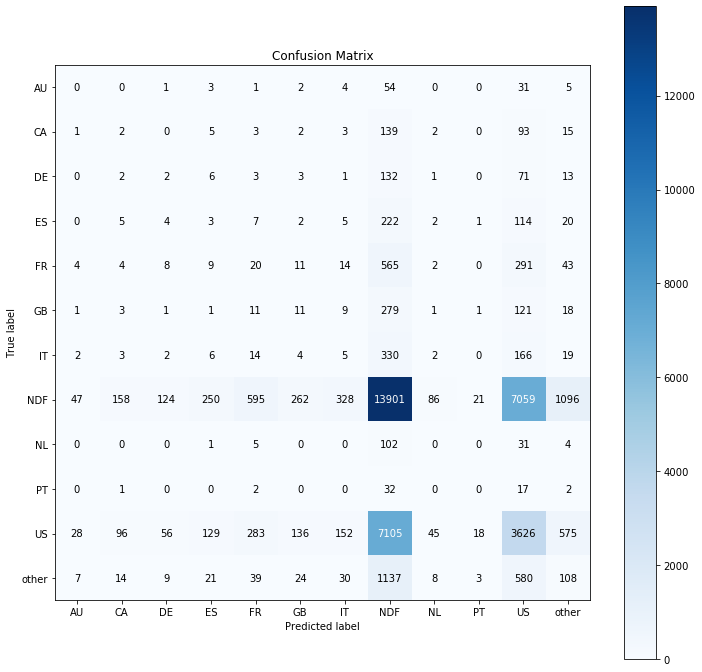

In [101]:
# Accuracy
acc_random = m.accuracy_score( y_test, yhat_random )
print(f'Accuracy {acc_random}')

# Balanced Accuracy
balanced_acc_random = m.balanced_accuracy_score(y_test, yhat_random)
print(f'Balanced Accuracy: {balanced_acc_random}')

# Kappa Metrics
kappa_random = m.cohen_kappa_score(y_test, yhat_random)
print(f'Kappa Score: {kappa_random}')

# Classification report
print(m.classification_report(y_test, yhat_random))

# Confusion Matrix
mt.plot_confusion_matrix(y_test, yhat_random, normalize=False, figsize=(12,12));

## 7.2. Neural Network - MLP

### 7.2.1. Neural Network - Imbalanced Data

In [93]:
ohe = pp.OneHotEncoder()

y_train_nn = ohe.fit_transform(y_train.values.reshape(-1, 1)).toarray()

In [94]:
# model definition
model = ml.Sequential()
model.add( l.Dense(128, input_dim=x_train.shape[1], activation='relu') )
model.add( l.Dense(12, activation='softmax') )

# model compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train model
model.fit(x_train, y_train_nn, epochs=100)

Epoch 1/100
5165/5165 [==============================] - 8s 2ms/step - loss: 0.5448 - accuracy: 0.8665
Epoch 2/100
5165/5165 [==============================] - 7s 1ms/step - loss: 0.5108 - accuracy: 0.8734
Epoch 3/100
5165/5165 [==============================] - 7s 1ms/step - loss: 0.5053 - accuracy: 0.8735
Epoch 4/100
5165/5165 [==============================] - 6s 1ms/step - loss: 0.5001 - accuracy: 0.8736
Epoch 5/100
5165/5165 [==============================] - 8s 2ms/step - loss: 0.5011 - accuracy: 0.8736
Epoch 6/100
5165/5165 [==============================] - 7s 1ms/step - loss: 0.4989 - accuracy: 0.8737
Epoch 7/100
5165/5165 [==============================] - 7s 1ms/step - loss: 0.4992 - accuracy: 0.8736
Epoch 8/100
5165/5165 [==============================] - 6s 1ms/step - loss: 0.4974 - accuracy: 0.8736
Epoch 9/100
5165/5165 [==============================] - 8s 2ms/step - loss: 0.4954 - accuracy: 0.8737
Epoch 10/100
5165/5165 [==============================] - 7s 1ms/step - l

5165/5165 [==============================] - 6s 1ms/step - loss: 0.4854 - accuracy: 0.8738
Epoch 77/100
5165/5165 [==============================] - 7s 1ms/step - loss: 0.4845 - accuracy: 0.8738
Epoch 78/100
5165/5165 [==============================] - 5s 942us/step - loss: 0.4933 - accuracy: 0.8738
Epoch 79/100
5165/5165 [==============================] - 5s 911us/step - loss: 0.4835 - accuracy: 0.8738
Epoch 80/100
5165/5165 [==============================] - 5s 1ms/step - loss: 0.4852 - accuracy: 0.8738
Epoch 81/100
5165/5165 [==============================] - 5s 1ms/step - loss: 0.4794 - accuracy: 0.8738
Epoch 82/100
5165/5165 [==============================] - 5s 923us/step - loss: 0.4899 - accuracy: 0.8738
Epoch 83/100
5165/5165 [==============================] - 5s 992us/step - loss: 0.4814 - accuracy: 0.8738
Epoch 84/100
5165/5165 [==============================] - 5s 949us/step - loss: 0.4867 - accuracy: 0.8738
Epoch 85/100
5165/5165 [==============================] - 5s 1ms/st

#### 7.2.1.1 Imbalanced Data - Performance

In [102]:
# prediction
pred_nn = model.predict(x_test)

# invert prediction
yhat_nn = ohe.inverse_transform(pred_nn)

# test dataset prepare with real results
y_test_nn = y_test.to_numpy()
yhat_nn = yhat_nn.reshape(1, -1)[0]

In [103]:
# check balanced results
pd.DataFrame(yhat_nn).value_counts(normalize=True)

NDF      0.579104
US       0.420606
other    0.000169
IT       0.000097
NL       0.000024
dtype: float64

Accuracy: 0.8751179844623539
Balanced Accuracy: 0.16656097234889475
Kappa Score: 0.7687176029607274
              precision    recall  f1-score   support

          AU       0.00      0.00      0.00       101
          CA       0.00      0.00      0.00       265
          DE       0.00      0.00      0.00       234
          ES       0.00      0.00      0.00       385
          FR       0.00      0.00      0.00       971
          GB       0.00      0.00      0.00       457
          IT       0.00      0.00      0.00       553
         NDF       1.00      1.00      1.00     23927
          NL       0.00      0.00      0.00       143
          PT       0.00      0.00      0.00        54
          US       0.70      1.00      0.83     12249
       other       0.00      0.00      0.00      1980

    accuracy                           0.88     41319
   macro avg       0.14      0.17      0.15     41319
weighted avg       0.79      0.88      0.82     41319



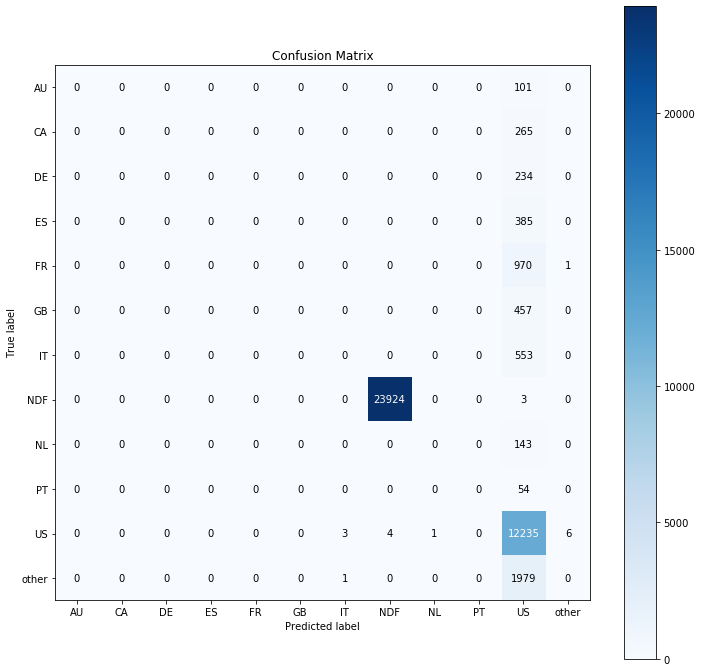

In [104]:
# Accuracy
acc_nn = m.accuracy_score( y_test_nn, yhat_nn )
print(f'Accuracy: {acc_nn}')

# Balanced Accuracy
balanced_acc_nn = m.balanced_accuracy_score(y_test_nn, yhat_nn)
print(f'Balanced Accuracy: {balanced_acc_nn}')

# Kappa Metrics
kappa_nn = m.cohen_kappa_score(y_test_nn, yhat_nn)
print(f'Kappa Score: {kappa_nn}')

# Classification report
print(m.classification_report(y_test_nn, yhat_nn))

# Confusion Matrix
mt.plot_confusion_matrix( y_test_nn, yhat_nn, normalize=False, figsize=(12,12));

### 7.2.2. Neural Network - Random Undersampling

In [95]:
ohe_under = pp.OneHotEncoder()

y_train_under_nn = ohe_under.fit_transform(y_train_under.values.reshape(-1, 1)).toarray()

In [96]:
# model definition
model_under = ml.Sequential()
model_under.add( l.Dense(128, input_dim=x_train_under.shape[1], activation='relu') )
model_under.add( l.Dense(12, activation='softmax') )

# model compile
model_under.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train model
model_under.fit(x_train_under, y_train_under_nn, epochs=100)

Epoch 1/100
64/64 [==============================] - 0s 1ms/step - loss: 2.4758 - accuracy: 0.1380
Epoch 2/100
64/64 [==============================] - 0s 1ms/step - loss: 2.2638 - accuracy: 0.1844
Epoch 3/100
64/64 [==============================] - 0s 2ms/step - loss: 2.2352 - accuracy: 0.1791
Epoch 4/100
64/64 [==============================] - 0s 2ms/step - loss: 2.2185 - accuracy: 0.1981
Epoch 5/100
64/64 [==============================] - 0s 1ms/step - loss: 2.2081 - accuracy: 0.1825
Epoch 6/100
64/64 [==============================] - 0s 1ms/step - loss: 2.1984 - accuracy: 0.1825
Epoch 7/100
64/64 [==============================] - 0s 2ms/step - loss: 2.1839 - accuracy: 0.1947
Epoch 8/100
64/64 [==============================] - 0s 1ms/step - loss: 2.1785 - accuracy: 0.2089
Epoch 9/100
64/64 [==============================] - 0s 1ms/step - loss: 2.1748 - accuracy: 0.2109
Epoch 10/100
64/64 [==============================] - 0s 1ms/step - loss: 2.1660 - accuracy: 0.2153
Epoch 11/

64/64 [==============================] - 0s 1ms/step - loss: 1.8848 - accuracy: 0.3488
Epoch 83/100
64/64 [==============================] - 0s 1ms/step - loss: 1.8868 - accuracy: 0.3478
Epoch 84/100
64/64 [==============================] - 0s 1ms/step - loss: 1.8834 - accuracy: 0.3464
Epoch 85/100
64/64 [==============================] - 0s 1ms/step - loss: 1.8815 - accuracy: 0.3386
Epoch 86/100
64/64 [==============================] - 0s 1ms/step - loss: 1.8774 - accuracy: 0.3425
Epoch 87/100
64/64 [==============================] - 0s 1ms/step - loss: 1.8798 - accuracy: 0.3488
Epoch 88/100
64/64 [==============================] - 0s 1ms/step - loss: 1.8701 - accuracy: 0.3469
Epoch 89/100
64/64 [==============================] - 0s 1ms/step - loss: 1.8693 - accuracy: 0.3469
Epoch 90/100
64/64 [==============================] - 0s 1ms/step - loss: 1.8730 - accuracy: 0.3439
Epoch 91/100
64/64 [==============================] - 0s 1ms/step - loss: 1.8764 - accuracy: 0.3483
Epoch 92/100


#### 7.2.2.1. Random Undersampling - Performance

In [105]:
# prediction
pred_under_nn = model_under.predict(x_test_under)

# invert prediction
yhat_under_nn = ohe_under.inverse_transform(pred_under_nn)

# test dataset prepare with real results
y_test_under_nn = y_test_under.to_numpy()
yhat_under_nn = yhat_under_nn.reshape(1, -1)[0]

In [106]:
# check balanced results
pd.DataFrame(yhat_under_nn).value_counts(normalize=True)

CA       0.144531
AU       0.125000
NL       0.105469
ES       0.091797
NDF      0.091797
DE       0.083984
FR       0.083984
US       0.072266
IT       0.056641
PT       0.050781
other    0.050781
GB       0.042969
dtype: float64

Accuracy: 0.173828125
Balanced Accuracy: 0.17115431351773344
Kappa Score: 0.09979050975958503
              precision    recall  f1-score   support

          AU       0.08      0.12      0.09        43
          CA       0.08      0.14      0.10        43
          DE       0.16      0.16      0.16        45
          ES       0.06      0.07      0.06        46
          FR       0.09      0.11      0.10        35
          GB       0.18      0.08      0.11        50
          IT       0.14      0.07      0.10        55
         NDF       0.96      1.00      0.98        45
          NL       0.04      0.06      0.05        32
          PT       0.04      0.02      0.03        47
          US       0.11      0.11      0.11        38
       other       0.15      0.12      0.14        33

    accuracy                           0.17       512
   macro avg       0.17      0.17      0.17       512
weighted avg       0.18      0.17      0.17       512



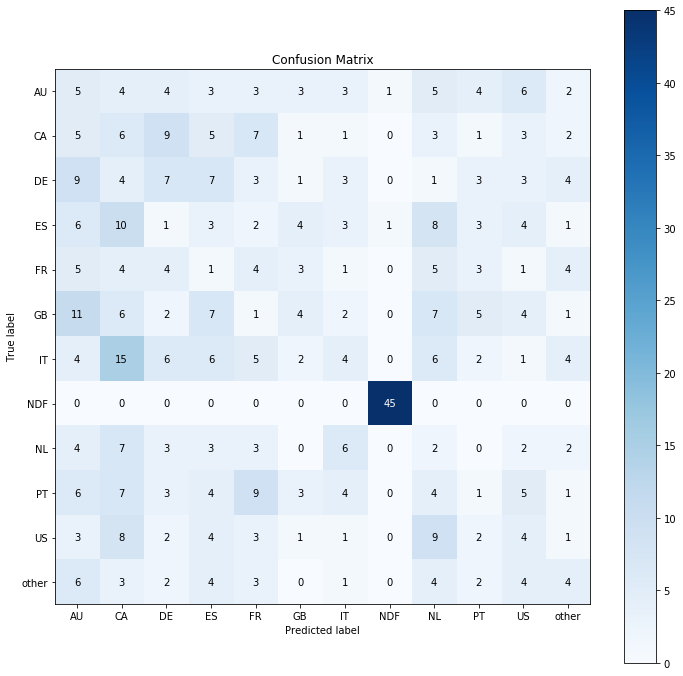

In [107]:
# Accuracy
acc_under_nn = m.accuracy_score( y_test_under_nn, yhat_under_nn )
print(f'Accuracy: {acc_under_nn}')

# Balanced Accuracy
balanced_acc_under_nn = m.balanced_accuracy_score(y_test_under_nn, yhat_under_nn)
print(f'Balanced Accuracy: {balanced_acc_under_nn}')

# Kappa Metrics
kappa_under_nn = m.cohen_kappa_score(y_test_under_nn, yhat_under_nn)
print(f'Kappa Score: {kappa_under_nn}')

# Classification report
print(m.classification_report(y_test_under_nn, yhat_under_nn))

# Confusion Matrix
mt.plot_confusion_matrix( y_test_under_nn, yhat_under_nn, normalize=False, figsize=(12,12));

### 7.2.3. Neural Network - Random Oversampling

In [97]:
ohe_over = pp.OneHotEncoder()

y_train_over_nn = ohe_over.fit_transform(y_train_over.values.reshape(-1, 1)).toarray()

In [98]:
# model definition
model_over = ml.Sequential()
model_over.add( l.Dense(128, input_dim=x_train_over.shape[1], activation='relu') )
model_over.add( l.Dense(12, activation='softmax') )

# model compile
model_over.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train model
model_over.fit(x_train_over, y_train_over_nn, epochs=100)

Epoch 1/100
35943/35943 [==============================] - 48s 1ms/step - loss: 2.0777 - accuracy: 0.2619
Epoch 2/100
35943/35943 [==============================] - 43s 1ms/step - loss: 1.9337 - accuracy: 0.3174
Epoch 3/100
35943/35943 [==============================] - 46s 1ms/step - loss: 1.8860 - accuracy: 0.3313 0s - loss: 1.8860 
Epoch 4/100
35943/35943 [==============================] - 43s 1ms/step - loss: 1.8617 - accuracy: 0.3385
Epoch 5/100
35943/35943 [==============================] - 34s 951us/step - loss: 1.8466 - accuracy: 0.3434
Epoch 6/100
35943/35943 [==============================] - 46s 1ms/step - loss: 1.8351 - accuracy: 0.3466
Epoch 7/100
35943/35943 [==============================] - 39s 1ms/step - loss: 1.8277 - accuracy: 0.3485
Epoch 8/100
35943/35943 [==============================] - 38s 1ms/step - loss: 1.8221 - accuracy: 0.3502
Epoch 9/100
35943/35943 [==============================] - 43s 1ms/step - loss: 1.8175 - accuracy: 0.3511
Epoch 10/100
35943/35943 

35943/35943 [==============================] - 39s 1ms/step - loss: 1.7743 - accuracy: 0.3654
Epoch 73/100
35943/35943 [==============================] - 38s 1ms/step - loss: 1.7739 - accuracy: 0.3654
Epoch 74/100
35943/35943 [==============================] - 38s 1ms/step - loss: 1.7738 - accuracy: 0.3653
Epoch 75/100
35943/35943 [==============================] - 45s 1ms/step - loss: 1.7738 - accuracy: 0.3651
Epoch 76/100
35943/35943 [==============================] - 34s 936us/step - loss: 1.7744 - accuracy: 0.3649
Epoch 77/100
35943/35943 [==============================] - 35s 963us/step - loss: 1.7738 - accuracy: 0.3653
Epoch 78/100
35943/35943 [==============================] - 33s 926us/step - loss: 1.7741 - accuracy: 0.3655
Epoch 79/100
35943/35943 [==============================] - 34s 934us/step - loss: 1.7738 - accuracy: 0.3654
Epoch 80/100
35943/35943 [==============================] - 34s 938us/step - loss: 1.7732 - accuracy: 0.3656
Epoch 81/100
35943/35943 [==============

#### 7.2.3.1. Random Oversampling - Performance

In [108]:
# prediction
pred_over_nn = model_over.predict(x_test_over)

# invert prediction
yhat_over_nn = ohe_over.inverse_transform(pred_over_nn)

# test dataset prepare with real results
y_test_over_nn = y_test_over.to_numpy()
yhat_over_nn = yhat_over_nn.reshape(1, -1)[0]

In [109]:
# check balanced results
pd.DataFrame(yhat_over_nn).value_counts(normalize=True)

NL       0.213988
AU       0.147946
CA       0.132877
DE       0.098708
PT       0.086641
NDF      0.083646
ES       0.076986
other    0.044421
US       0.038147
IT       0.030712
GB       0.028142
FR       0.017785
dtype: float64

Accuracy: 0.3692547923100465
Balanced Accuracy: 0.3690339933077116
Kappa Score: 0.31180525397696646
              precision    recall  f1-score   support

          AU       0.43      0.77      0.55     23979
          CA       0.20      0.32      0.25     24024
          DE       0.24      0.29      0.26     24042
          ES       0.17      0.16      0.16     23971
          FR       0.19      0.04      0.07     24083
          GB       0.19      0.06      0.10     23936
          IT       0.18      0.07      0.10     23859
         NDF       1.00      1.00      1.00     24038
          NL       0.24      0.60      0.34     24168
          PT       0.92      0.96      0.94     23785
          US       0.15      0.07      0.10     23828
       other       0.16      0.08      0.11     23831

    accuracy                           0.37    287544
   macro avg       0.34      0.37      0.33    287544
weighted avg       0.34      0.37      0.33    287544



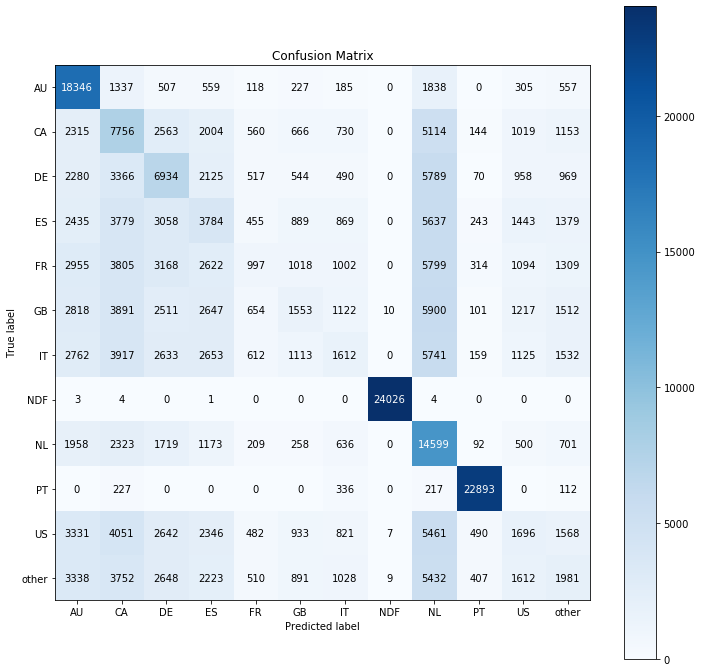

In [110]:
# Accuracy
acc_over_nn = m.accuracy_score( y_test_over_nn, yhat_over_nn )
print(f'Accuracy: {acc_over_nn}')

# Balanced Accuracy
balanced_acc_over_nn = m.balanced_accuracy_score(y_test_over_nn, yhat_over_nn)
print(f'Balanced Accuracy: {balanced_acc_over_nn}')

# Kappa Metrics
kappa_over_nn = m.cohen_kappa_score(y_test_over_nn, yhat_over_nn)
print(f'Kappa Score: {kappa_over_nn}')

# Classification report
print(m.classification_report(y_test_over_nn, yhat_over_nn))

# Confusion Matrix
mt.plot_confusion_matrix( y_test_over_nn, yhat_over_nn, normalize=False, figsize=(12,12));

### 7.2.4. Neural Network - SMOTE + TOMEKLINK

In [99]:
ohe_comb = pp.OneHotEncoder()

y_train_comb_nn = ohe_comb.fit_transform(y_train_comb.values.reshape(-1, 1)).toarray()

In [100]:
# model definition
model_comb = ml.Sequential()
model_comb.add( l.Dense(128, input_dim=x_train_comb.shape[1], activation='relu') )
model_comb.add( l.Dense(12, activation='softmax') )

# model compile
model_comb.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train model
model_comb.fit(x_train_comb, y_train_comb_nn, epochs=100)

Epoch 1/100
35932/35932 [==============================] - 35s 982us/step - loss: 2.0892 - accuracy: 0.2559
Epoch 2/100
35932/35932 [==============================] - 36s 993us/step - loss: 1.9944 - accuracy: 0.2971
Epoch 3/100
35932/35932 [==============================] - 36s 1ms/step - loss: 1.9646 - accuracy: 0.3093
Epoch 4/100
35932/35932 [==============================] - 49s 1ms/step - loss: 1.9489 - accuracy: 0.3162
Epoch 5/100
35932/35932 [==============================] - 62s 2ms/step - loss: 1.9396 - accuracy: 0.3207 0s - loss: 1.9396 - accuracy: 0.
Epoch 6/100
35932/35932 [==============================] - 57s 2ms/step - loss: 1.9318 - accuracy: 0.3234 2s - loss: 1.9320 - accuracy - ETA: 2s - loss: 1
Epoch 7/100
35932/35932 [==============================] - 39s 1ms/step - loss: 1.9264 - accuracy: 0.3254
Epoch 8/100
35932/35932 [==============================] - 57s 2ms/step - loss: 1.9223 - accuracy: 0.3271
Epoch 9/100
35932/35932 [==============================] - 50s 1ms

35932/35932 [==============================] - 36s 1ms/step - loss: 1.8849 - accuracy: 0.3399 0s - loss:
Epoch 75/100
35932/35932 [==============================] - 33s 927us/step - loss: 1.8821 - accuracy: 0.3402
Epoch 76/100
35932/35932 [==============================] - 33s 909us/step - loss: 1.8814 - accuracy: 0.3404
Epoch 77/100
35932/35932 [==============================] - 34s 955us/step - loss: 1.8817 - accuracy: 0.3404
Epoch 78/100
35932/35932 [==============================] - 33s 930us/step - loss: 1.8812 - accuracy: 0.3401
Epoch 79/100
35932/35932 [==============================] - 38s 1ms/step - loss: 1.8813 - accuracy: 0.3406
Epoch 80/100
35932/35932 [==============================] - 40s 1ms/step - loss: 1.8815 - accuracy: 0.3400
Epoch 81/100
35932/35932 [==============================] - 56s 2ms/step - loss: 1.8820 - accuracy: 0.3404
Epoch 82/100
35932/35932 [==============================] - 58s 2ms/step - loss: 1.8808 - accuracy: 0.3401
Epoch 83/100
35932/35932 [=====

#### 7.2.4.1. SMOTE + TOMEKLINK - Performance

In [111]:
# prediction
pred_comb_nn = model_comb.predict(x_test_comb)

# invert prediction
yhat_comb_nn = ohe_comb.inverse_transform(pred_comb_nn)

# test dataset prepare with real results
y_test_comb_nn = y_test_comb.to_numpy()
yhat_comb_nn = yhat_comb_nn.reshape(1, -1)[0]

In [112]:
# check balanced results
pd.DataFrame(yhat_comb_nn).value_counts(normalize=True)

PT       0.127015
AU       0.120725
DE       0.120263
NL       0.110195
CA       0.103940
IT       0.094704
NDF      0.083401
US       0.066971
other    0.065266
ES       0.049465
GB       0.035310
FR       0.022745
dtype: float64

Accuracy: 0.3398213279342086
Balanced Accuracy: 0.3400674801304327
Kappa Score: 0.27979382744064274
              precision    recall  f1-score   support

          AU       0.38      0.55      0.45     23982
          CA       0.21      0.26      0.23     24029
          DE       0.24      0.34      0.28     23884
          ES       0.18      0.11      0.14     24022
          FR       0.18      0.05      0.08     23859
          GB       0.17      0.07      0.10     24079
          IT       0.16      0.18      0.17     23973
         NDF       1.00      1.00      1.00     23911
          NL       0.29      0.38      0.33     24285
          PT       0.55      0.84      0.66     23794
          US       0.21      0.17      0.19     23738
       other       0.16      0.13      0.14     23898

    accuracy                           0.34    287454
   macro avg       0.31      0.34      0.31    287454
weighted avg       0.31      0.34      0.31    287454



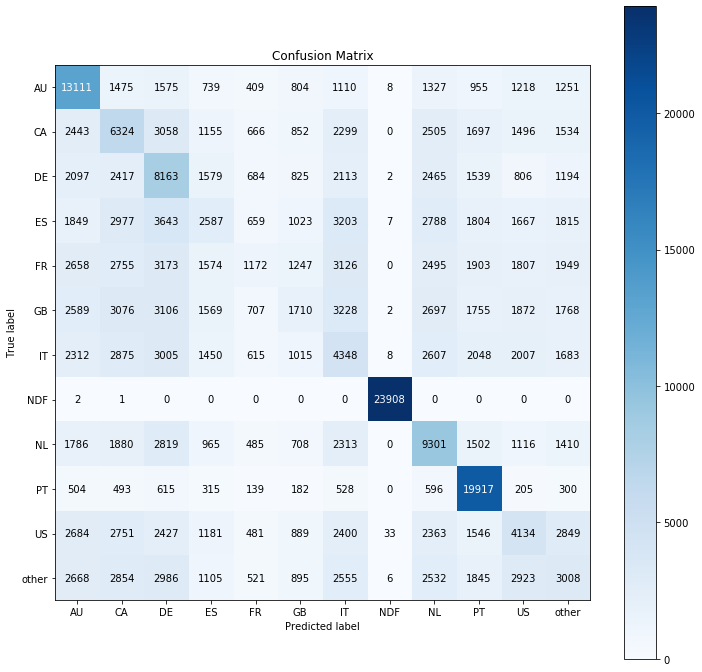

In [113]:
# Accuracy
acc_comb_nn = m.accuracy_score( y_test_comb_nn, yhat_comb_nn )
print(f'Accuracy: {acc_comb_nn}')

# Balanced Accuracy
balanced_acc_comb_nn = m.balanced_accuracy_score(y_test_comb_nn, yhat_comb_nn)
print(f'Balanced Accuracy: {balanced_acc_comb_nn}')

# Kappa Metrics
kappa_comb_nn = m.cohen_kappa_score(y_test_comb_nn, yhat_comb_nn)
print(f'Kappa Score: {kappa_comb_nn}')

# Classification report
print(m.classification_report(y_test_comb_nn, yhat_comb_nn))

# Confusion Matrix
mt.plot_confusion_matrix( y_test_comb_nn, yhat_comb_nn, normalize=False, figsize=(12,12));

## 7.3. Neural Network Performance - Cross-Validation

In [114]:
# # generate k-fold
# num_folds = 5
# kfold = ms.StratifiedKFold( n_splits=num_folds, shuffle=True, random_state=32 )

# balanced_acc_list = []

# kappa_list = []

# i = 1

# for train_index, val_index in kfold.split( x_train, y_train ):
#     print(f'Fold Number:{i}/{num_folds}')
    
#     # split data into training and test set
#     x_train_cv = x_train.iloc[train_index]
#     y_train_cv = y_train.iloc[train_index]
    
#     x_validation_cv = x_train.iloc[val_index]
#     y_validation_cv = y_train.iloc[val_index]
    
#     # encoding response variable
#     ohe = pp.OneHotEncoder()

#     y_train_cv_nn = ohe.fit_transform(y_train_cv.values.reshape(-1, 1)).toarray()

#     # model definition
#     model = ml.Sequential()
#     model.add( l.Dense(128, input_dim=x_train_cv.shape[1], activation='relu') )
#     model.add( l.Dense(12, activation='softmax') )

#     # model compile
#     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#     # train model
#     model.fit(x_train_cv, y_train_cv_nn, epochs=100, batch_size=32, verbose=0)

#     # prediction
#     pred_cv_nn = model.predict(x_validation_cv)

#     # invert prediction
#     yhat_cv_nn = ohe.inverse_transform(pred_cv_nn)

#     # test dataset prepare with real results
#     y_test_cv_nn = y_validation_cv.to_numpy()
#     yhat_cv_nn = yhat_cv_nn.reshape(1, -1)[0]
    
#     # performance metrics 
#     # Balanced Accuracy
#     balanced_acc_nn = m.balanced_accuracy_score(y_test_cv_nn, yhat_cv_nn)
#     balanced_acc_list.append(balanced_acc_nn)

#     # Kappa Metrics
#     kappa_nn = m.cohen_kappa_score(y_test_cv_nn, yhat_cv_nn)
#     kappa_list.append(kappa_nn)
    
#     i += 1

In [115]:
# print(f'Avg Balanced Accuracy: {np.round(np.mean(balanced_acc_list), 2)} +/- {np.round(np.std(balanced_acc_list),5)}')
# print(f'Avg Kappa Score: {np.round(np.mean(kappa_list), 2)} +/- {np.round(np.std(kappa_list), 4)}')

# 8.0. Hyper Parameter Tuning

Hyper Parameter Tuning will not be considered until the most optimal machine learning model is selected, at this first cycle was considered only one model to complete the cycle and go through for all the major phases to validate the feasibility of the project.

# 9.0. Error Translation and Interpretation

## 9.2. Neural Network Performance

# 10.0. Deploy Model

No models will be deployed yet.

# Result

The use of sampling methods to handle the imbalanced dataset did not yield positive results in the model's performance metrics.

The use of 3 mechanisms to obtain a balanced distribution of classes was considered, including Random Undersampling, Random Oversampling and a synthetic sampling with data generation (SMOTE + Tomek links).

The balanced datasets showed similar results to each other and little difference to the previous cycle, with only the Kappa Score much lower(0.70 to 0.09).

The only difference observed was in the distribution of classes in the prediction data, with a greater plurality, previously concentrated between the two marjority classes (NDF and US).